# Reinforce, Monte-Carlo Policy-Gradient With Baseline

This notebook demonstates an improved version of the Reinforce policy gradient method, called Reinforce with Baseline. This is the Monte-Carlo version of Reinforce, which means the model can only be updated after the episode has terminated. We will be using the Cartpole environment, since episode termination is easy to achieve on this problem. Monte-Carlo algorithms are not well suited to environments that don't provide a straight forward termination path, because they can get stuck in an infinite loop and never complete the first episode, due to not being able to learn during the episode.

Unlike the vanilla Reinforce, we will be using a state-value function to assist with training. The state-value function will help reduce variance in the sample estimate for the policy gradient and ensure the model converges to the optimal solution quicker. We will be using multi-layer perceptron's for both the policy function and state-value function. The algorithm is on-policy, so it starts by generating an episode $S_0, A_0, R_1, ..., S_{T-1}, A_{T-1}, R_T$, following the policy, $\pi_\theta$, until the terminal time step $T$. After the episode has completed, the policy, $\pi_\theta$, and state-value functions, $\hat{v}(S_t, w)$, weights are updated. The state-value function will be used as a baseline, which will be subtracted by the return, $G_t$, to give us the error, $\delta$. $\delta$, is given by:
$$\delta_t \leftarrow G_t - \hat{v}(S_t, w),$$
where $G_t$ is the discounted return from timestep $t$, given by,
$$G_t \leftarrow \sum_{k=t+1}^{T}\gamma^{k-t-1}R_k,$$
where $\gamma$ is the discount rate, and $R_k$ is the reward at time step $k$. The error, $\delta$, is then used in place of the return to update the state-value parameters, $w$, in the following update:
$$w \leftarrow w + \alpha^{w}\nabla\hat{v}(S_t, w)\delta_t,$$
where $\alpha$ is the step-size or learning rate. The error, $\delta$, is also used in place of the return to update policy parameters, $\theta$, in the following update:
$$\theta \leftarrow \theta + \alpha^{\theta} \nabla_\theta \log(\pi_\theta(a_t | s_t))\delta_t.$$

Using the error, $\delta$, in-place of the return, $G_t$, ensures that the performance of an action taken is easier to measure. For example in the Cartpole problem the rewards are based on time spent in a non-terminal state. This results in a linear decrease in the returns from the earlier states to the later states. Regardless of the action taken in the first few states, the returns will always be high, this results in a small difference in return between taking a bad action and a good action. Similarly in the last few states the returns will be low regardless of whether a good or bad action was taken. But when using the state-value baseline, the return from the action is essentially compared against the expected average return in that state. So choosing a bad action will result in a lower return than the state-value functions expected return, resulting in a negative $\delta$. If the action is better than the state-value functions expected return then the $\delta$ will be positive. This ensures that the direction and size of the parameter update is more appropriate for the action taken in that state. 

For more information on the Reinforce Baseline algorithm, see OpenAI's post [Baselines in Policy Gradients](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#baselines-in-policy-gradients), and chapter 13.4 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf).


In [146]:
import os
import gymnasium as gym
import numpy as np
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import jax
import flax.linen as nn
from jax import random
from jax import grad, value_and_grad
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

In [147]:
# Type of environment, options include:
# CartPole-v1
ENV_TYPE = "CartPole-v1"

# Save videos from training
SAVE_VIDEOS = True
VIDEOS_ROOT_DIR = './videos/reinforce_baseline/'

In [148]:
# Create the environment
env = gym.make(ENV_TYPE, render_mode="rgb_array")

# Number of possible states and actions
num_actions = env.action_space.n
obs_dims = env.observation_space.shape
obs_upper_bounds = env.observation_space.high
obs_lower_bounds = env.observation_space.low

## Create The Policy 

In [149]:
class _policy_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(64)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(num_actions)(x)
        return jax.nn.softmax(x)

# Create the model object
policy_fn = _policy_fn()
# Display the model details
dummy_x, _ = env.reset()
rng_key = random.PRNGKey(64)
print(policy_fn.tabulate(rng_key, dummy_x))


                               _policy_fn Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module     ┃ inputs       ┃ outputs      ┃ params                  ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ _policy_fn │ float32[4]   │ float32[2]   │                         │
├─────────┼────────────┼──────────────┼──────────────┼─────────────────────────┤
│ Dense_0 │ Dense      │ float32[4]   │ float32[256] │ bias: float32[256]      │
│         │            │              │              │ kernel: float32[4,256]  │
│         │            │              │              │                         │
│         │            │              │              │ 1,280 (5.1 KB)          │
├─────────┼────────────┼──────────────┼──────────────┼─────────────────────────┤
│ Dense_1 │ Dense      │ float32[256] │ float32[64]  │ bias: float32[64]       │
│         │            │   

In [150]:
class _value_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Create the model object
value_fn = _value_fn()
# Display the model details
print(value_fn.tabulate(rng_key, dummy_x))


                              _value_fn Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs       ┃ outputs      ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ _value_fn │ float32[4]   │ float32[1]   │                        │
├─────────┼───────────┼──────────────┼──────────────┼────────────────────────┤
│ Dense_0 │ Dense     │ float32[4]   │ float32[256] │ bias: float32[256]     │
│         │           │              │              │ kernel: float32[4,256] │
│         │           │              │              │                        │
│         │           │              │              │ 1,280 (5.1 KB)         │
├─────────┼───────────┼──────────────┼──────────────┼────────────────────────┤
│ Dense_1 │ Dense     │ float32[256] │ float32[1]   │ bias: float32[1]       │
│         │           │              │             

In [151]:
def policy_loss_fn(policy_variables, value_variables, states, actions, returns):
    action_dists = policy_fn.apply(policy_variables, states)
    probs = action_dists[jnp.arange(len(actions)), actions]
    values = value_fn.apply(value_variables, states)
    values = values.flatten()
    errors = returns - values
    log_probs = jnp.log(probs)
    loss = -(log_probs * errors).mean()
    return loss 

In [152]:
def value_loss_fn(variables, states, returns):
    values = value_fn.apply(variables, states)
    values = values.flatten()
    errors = returns - values
    loss = (errors * values).mean()
    return loss 

## Learn The Optimal Action-Value Function

In [153]:
# Number of episodes to train on
episodes = 51
# Sliding window for episode evaluation (needs to be less than episodes)
episode_window = 5
# Discount ratio
gamma = 0.99 
# Step size
policy_alpha = 0.001
value_alpha = 0.001

policy_variables = policy_fn.init(rng_key, dummy_x)
policy_optimizer = optax.adam(learning_rate=policy_alpha)
policy_opt_state = policy_optimizer.init(policy_variables)

value_variables = value_fn.init(rng_key, dummy_x)
value_optimizer = optax.adam(learning_rate=value_alpha)
value_opt_state = value_optimizer.init(value_variables)

env = gym.make(ENV_TYPE, render_mode="rgb_array")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)

if SAVE_VIDEOS:
    os.makedirs(VIDEOS_ROOT_DIR, exist_ok=True)
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder=VIDEOS_ROOT_DIR,
        episode_trigger=lambda episode: episode % 10 == 0,
        video_length=0,
        name_prefix=ENV_TYPE
        )

for episode in range(1, episodes+1):
    terminated, truncated = False, False
    reward = 0
    rewards = []
    state, info = env.reset()
    states = []
    actions = []
    # Generate an episode following the policy
    while not (terminated or truncated):
        states.append(state)
        # Select the action following the parametrized policy
        action_dist = policy_fn.apply(policy_variables, state)
        action_dist = np.array(action_dist).astype(np.float64)
        # Divide by the total to ensure the values sum to one
        action_dist /= action_dist.sum()
        action = np.random.choice(np.arange(num_actions), p=action_dist)
        actions.append(action)
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(int(action))
        rewards.append(reward)
        state = next_state


    rewards = jnp.array(rewards)
    states = jnp.array(states)
    actions = jnp.array(actions)

    T = len(states)
    weights = []
    # Update the policies parameters
    for t, state in enumerate(states):
        G = 0
        for k in range(t, T):
            G += (gamma**(k - t)) * rewards[k]
        weights.append(G)
    weights = jnp.array(weights)

    value_loss, value_grads = value_and_grad(value_loss_fn, argnums=0)(value_variables, states, weights)
    value_updates, value_opt_state = value_optimizer.update(value_grads, value_opt_state, value_variables)
    value_variables = optax.apply_updates(value_variables, value_updates)

    policy_loss, policy_grads = value_and_grad(policy_loss_fn, argnums=0)(policy_variables, value_variables, states, actions, weights)
    policy_updates, policy_opt_state = policy_optimizer.update(policy_grads, policy_opt_state, policy_variables)
    policy_variables = optax.apply_updates(policy_variables, policy_updates)
            

    if episode % episode_window == 0:
        print(f'Episode {episode} Average Returns: {np.mean(np.array(env.return_queue).flatten()[-episode_window:]) :.2f}')

Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-0.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-0.mp4


Episode 5 Average Returns: 31.60
Episode 10 Average Returns: 24.60
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-10.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-10.mp4


Episode 15 Average Returns: 27.80
Episode 20 Average Returns: 53.80
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-20.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-20.mp4
Episode 25 Average Returns: 45.40
Episode 30 Average Returns: 61.80
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-30.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-30.mp4
Episode 35 Average Returns: 48.20
Episode 40 Average Returns: 62.20
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-40.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-40.mp4
Episode 45 Average Returns: 55.80
Episode 50 Average Returns: 35.40
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-50.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_baseline/CartPole-v1-episode-50.mp4


## Plot The Results

For cartpole rewards are assigned for the time spent in a non-terminal state. The episode length and rewards will be identical in this case.

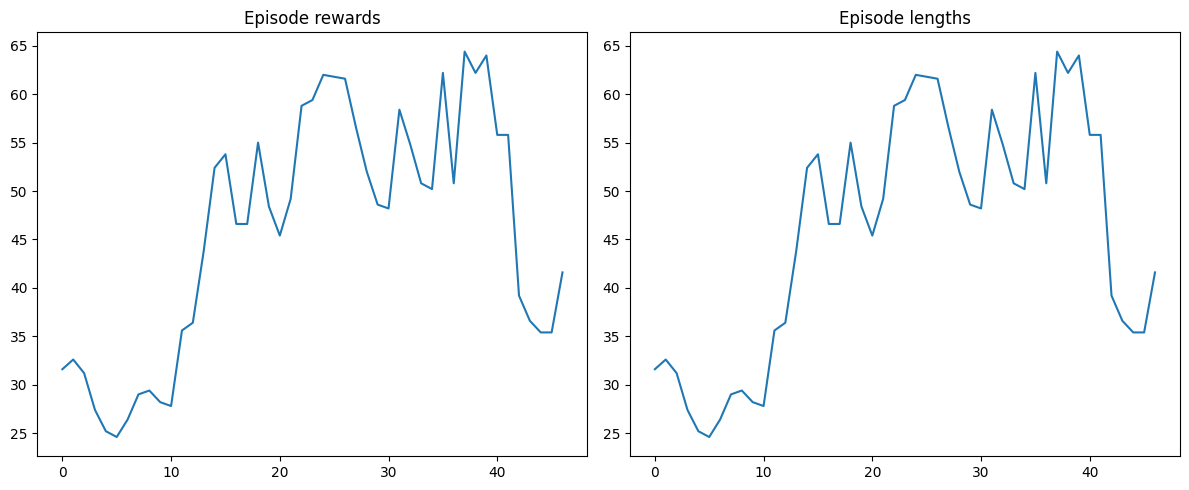

In [154]:
# Code used from: https://gymnasium.farama.org/tutorials/blackjack_tutorial/#visualizing-the-training
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

## Training Episode Videos

### Episode 0

In [155]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-0.mp4")

### Episode 10

In [156]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-10.mp4")

### Episode 20

In [157]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-20.mp4")

### Episode 30

In [158]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-30.mp4")

### Episode 40

In [159]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-40.mp4")

### Episode 50

In [160]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-50.mp4")